In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
!pip install xgboost

In [2]:
df_train = pd.read_csv('encoded_train_data1.csv')
df_test = pd.read_csv('encoded_test_data1.csv')
X_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']
X_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

In [3]:
# Ratio of negative to positive class
scale_pos_weightx = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [4]:
# Train XGBoost
model_xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weightx,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

F:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:35:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:


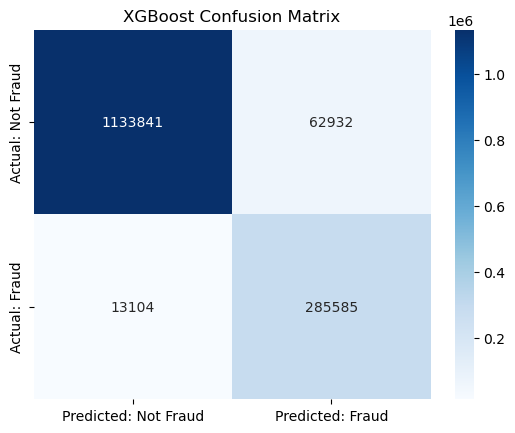


Classification Report (XGBoost):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.95      0.97   1196773
       Fraud       0.82      0.96      0.88    298689

    accuracy                           0.95   1495462
   macro avg       0.90      0.95      0.93   1495462
weighted avg       0.95      0.95      0.95   1495462

ROC AUC Score (XGBoost): 0.991196


In [5]:
# Evaluate XGBoost
print("\nXGBoost Results:")
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(pd.DataFrame(cm, index=['Actual: Not Fraud', 'Actual: Fraud'],
                         columns=['Predicted: Not Fraud', 'Predicted: Fraud']),
            annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=['Not Fraud', 'Fraud']))
print(f"ROC AUC Score (XGBoost): {roc_auc_score(y_test, y_proba_xgb):.6f}")


Logistic Regression Results:


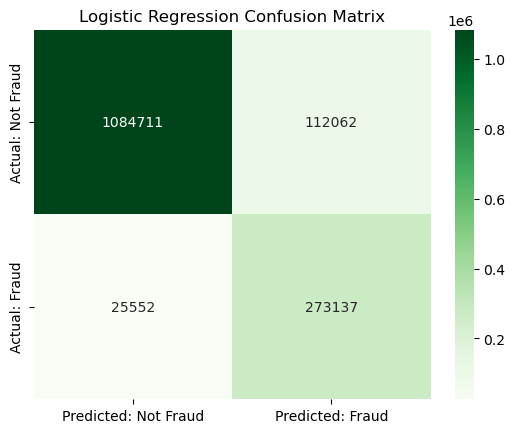


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

   Not Fraud       0.98      0.91      0.94   1196773
       Fraud       0.71      0.91      0.80    298689

    accuracy                           0.91   1495462
   macro avg       0.84      0.91      0.87   1495462
weighted avg       0.92      0.91      0.91   1495462

ROC AUC Score (Logistic Regression): 0.967977


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = model_lr.predict(X_test_scaled)
y_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

# Evaluate Logistic Regression
print("\nLogistic Regression Results:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(pd.DataFrame(cm_lr, index=['Actual: Not Fraud', 'Actual: Fraud'],
                         columns=['Predicted: Not Fraud', 'Predicted: Fraud']),
            annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=['Not Fraud', 'Fraud']))
print(f"ROC AUC Score (Logistic Regression): {roc_auc_score(y_test, y_proba_lr):.6f}")

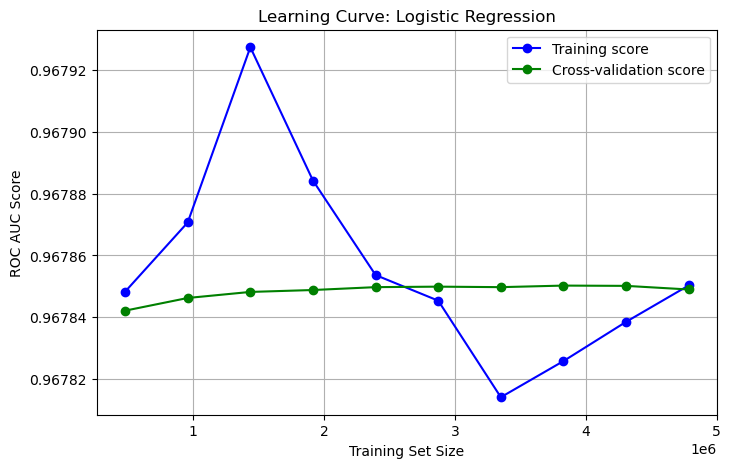

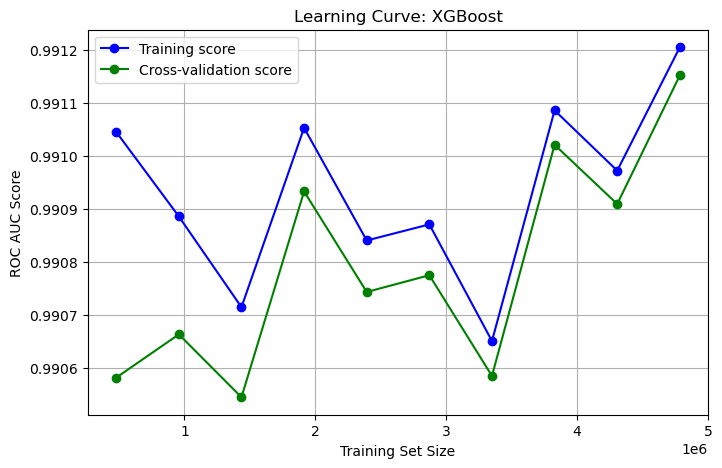

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

def plot_learning_curve(estimator, title, X, y, cv=5, scoring='roc_auc'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )

    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('ROC AUC Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Logistic Regression with scaling in a pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Plot learning curve for Logistic Regression
plot_learning_curve(lr_pipeline, "Learning Curve: Logistic Regression", X_train, y_train)

# XGBoost (no need to scale)
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weightx,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Plot learning curve for XGBoost
plot_learning_curve(xgb_model, "Learning Curve: XGBoost", X_train, y_train)